<a href="https://colab.research.google.com/github/varundubey2804/Stress_Level_Prediction/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.utils import to_categorical


In [ ]:
# Load Dataset

df = pd.read_csv('/content/all-samples.csv')

In [ ]:
df.size

8241605

In [ ]:
# Handle Missing Values
df = df.dropna()

In [ ]:
# Convert Categorical Features to Numeric (if any)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

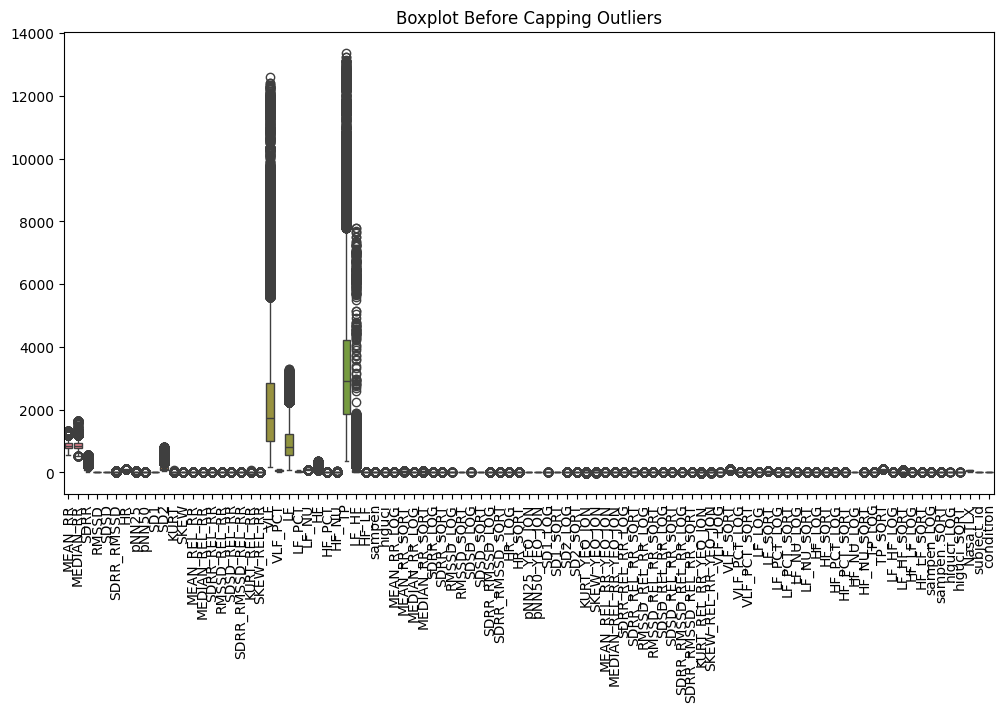

In [ ]:
# Boxplot Before Capping Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot Before Capping Outliers")
plt.show()


In [ ]:

def cap_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data.apply(lambda x: np.where(x < lower_bound[x.name], lower_bound[x.name], x))
    data = data.apply(lambda x: np.where(x > upper_bound[x.name], upper_bound[x.name], x))

    return data

df = cap_outliers_iqr(df)

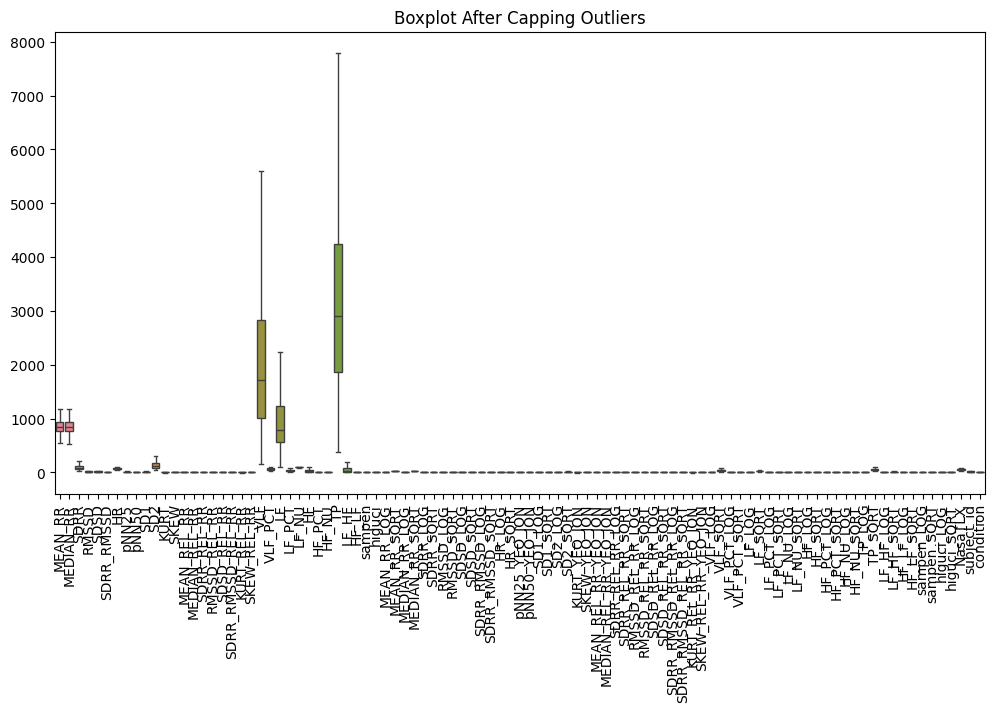

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot After Capping Outliers")
plt.show()


In [ ]:
# Define Features and Target
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Target

from sklearn.feature_selection import SelectKBest, f_classif


In [ ]:
# Define Features and Target
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Target


In [ ]:
# Convert Target Variable to Categorical (for LSTM)
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)


In [ ]:
# Feature Selection
num_features_to_select = 10  # Choose the number of features to keep
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, np.argmax(y, axis=1))  # Use argmax to convert one-hot y to labels


In [ ]:

# Feature Selection
num_features_to_select = 10  # Choose the number of features to keep
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, np.argmax(y, axis=1))  # Use argmax to convert one-hot y to labels



In [ ]:

num_features_to_select = 10
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, np.argmax(y, axis=1))

selected_features = selector.get_support()

selected_feature_names = df.columns[:-1][selected_features]
print(f"Selected Feature Names: {selected_feature_names.tolist()}")

Selected Feature Names: ['MEAN_RR', 'MEDIAN_RR', 'HR', 'MEAN_RR_LOG', 'MEAN_RR_SQRT', 'MEDIAN_RR_LOG', 'MEDIAN_RR_SQRT', 'HR_LOG', 'HR_SQRT', 'HF_PCT_SQRT']


In [ ]:
X_new.shape

(84964, 10)

In [ ]:
# Train-Test Split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


In [ ]:
# Normalize Features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
# Reshape Data for LSTM (LSTM needs 3D input: samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 158s 31ms/step - accuracy: 0.8348 - loss: 0.3872 - val_accuracy: 0.8735 - val_loss: 0.2977
Epoch 2/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 183s 27ms/step - accuracy: 0.8430 - loss: 0.3703 - val_accuracy: 0.8885 - val_loss: 0.2646
Epoch 3/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 158s 30ms/step - accuracy: 0.8567 - loss: 0.3412 - val_accuracy: 0.8978 - val_loss: 0.2472
Epoch 4/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 139s 27ms/step - accuracy: 0.8639 - loss: 0.3265 - val_accuracy: 0.9171 - val_loss: 0.2061
Epoch 5/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 148s 29ms/step - accuracy: 0.8738 - loss: 0.3083 - val_accuracy: 0.9184 - val_loss: 0.2013
Epoch 6/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 195s 28ms/step - accuracy: 0.8781 - loss: 0.2986 - val_accuracy: 0.9130 - val_loss: 0.2082
Epoch 7/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8848 - loss: 0.2832 - val_accuracy: 0.9339 - val_loss: 0.1724
Epoch 8/20
5123/5123 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - accuracy: 

In [ ]:

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9539 - loss: 0.1155
Test Accuracy: 95.31%


In [ ]:

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     13448
           1       0.93      0.97      0.95     13847
           2       0.96      0.96      0.96     13682

    accuracy                           0.95     40977
   macro avg       0.95      0.95      0.95     40977
weighted avg       0.95      0.95      0.95     40977

